# Introduction 💥

In this notebook, we will explore the data from the Playground Series S3E20 competition, which is about predicting if a person has at least on of three medical conditions based on measurements of health characteristics.

> Our goal is to achieve a low balanced log loss, which is the metric used for scoring this competition. 🎯

Join me on this journey as we uncover insights and patterns that will help us understand what factors influence the presence of medical conditions.

> Too many ideas too little submissions!

## We will go through
- How to perform **cross validation with upsampling the right way**
- Creating easy to use data **processing pipelines** using scikit-learn
- Using **PCA** to reduce dimensionality and create **stunning 3D plots**
- Optimizing the model hyperparameters using **optuna**
- Ensambling models to create a more robust one

## Table of Contents
1. [Libraries 📖](#Libraries-📖)
2. [Load data 📂](#Load-data-📁)
3. [Data analysis 📊](#Data-analysis-📊)
    1. [Train data anaysisi](#Train-data-analysis)
    2. [Greeks data analysis](#Greeks-data-analysis)
4. [Feature engineering 🛠️](#Feature-engineering-🛠️)
    1. [Date features](#Date-features)
    2. [Cyclic features](#Cyclic-features)
    3. [Drop columns](#Drop-columns)
5. [PCA visualization 👀](#PCA-visualization-👀)
6. [Preprocessing ⚙️](#Preprocessing-⚙️)
    1. [Split dataset](#Split-dataset)
    2. [Create a pipeline](#Create-a-pipeline)
7. [Modeling 🪄](#Modeling-🪄)
    1. [Balanced logarithmic loss](#Balanced-logarithmic-loss)
    2. [Hyperparameter optimization](#Hyperparameter-optimization)
    3. [Stacking models](#Stacking-models)
    4. [Model evaluation](#Model-evaluation)
8. [Submission 🏆](#Submission-🏆)
9. [Thank you ✨](#Thank-you-✨)

# Libraries 📖
***

In [1]:
# From https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min
# UNCOMMENT first with internet option turned on
# Use GPU env

# !pip download tabpfn --no-deps -d pip-packages
# !pip install tabpfn

# !mv /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt pip-packages/
# !zip -r pip-packages.zip pip-packages

# now you need to download the zip and upload it as dataset with the plus in the top left
# then you need to add it to the notebook as data on the right, and name it `pip-packages-icr`

# now you can turn internet off and still install, like below
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages

Looking in links: file:///kaggle/input/pip-packages-icr/pip-packages
Processing /kaggle/input/pip-packages-icr/pip-packages/tabpfn-0.1.9-py3-none-any.whl


In [2]:
!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [3]:
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.metrics import log_loss, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Imbalanced-learn, scikit for unbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Visualization
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier
from tabpfn import TabPFNClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Hyperparameter optimization
import optuna

# Misc
from datetime import datetime
import gc

# Random state
rs = 2137

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load data 📁
***

In [4]:
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv', index_col='Id')

# Data analysis 📊
***

<div class="warning" style="background-color: #ede9fe; border-left: 6px solid #7c3aed; font-size: 100%; padding: 10px;">
    <h3 style="color: #7c3aed; font-size: 18px; margin-top: 0; margin-bottom: 10px;">🪄  Competition insights</h3>
    <ul>
        <li><i>BN</i> collumn is propably an age (its <i>Class</i>=1 distribution is similar to distribution of patients in hospitals)</li>
        <li>If <i>BQ</i> is missing then <i>Class is</i> always 0.</li>
        <li>This comp is as close to roullete as it can be.</li>
    </ul>
</div>

## Training data analysis

In [5]:
train.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 617 entries, 000ff2bfdfe9 to ffcca4ded3bb
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      617 non-null    float64
 1   AF      617 non-null    float64
 2   AH      617 non-null    float64
 3   AM      617 non-null    float64
 4   AR      617 non-null    float64
 5   AX      617 non-null    float64
 6   AY      617 non-null    float64
 7   AZ      617 non-null    float64
 8   BC      617 non-null    float64
 9   BD      617 non-null    float64
 10  BN      617 non-null    float64
 11  BP      617 non-null    float64
 12  BQ      557 non-null    float64
 13  BR      617 non-null    float64
 14  BZ      617 non-null    float64
 15  CB      615 non-null    float64
 16  CC      614 non-null    float64
 17  CD      617 non-null    float64
 18  CF      617 non-null    float64
 19  CH      617 non-null    float64
 20  CL      617 non-null    float64
 21  CR      617 non-null    

<div style="border-radius: 10px; border: #ff001c solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> 🚩 Training size:</b> There is only 617 examples to train and validate our model. This may not be enough and introduce because it is also high dimensional data (56 columns). We will have to be careful not to overfit our model to such small dataset.
</div>

In [7]:
# Missing values in each column
missing = train.isnull().sum()
missing[missing > 0]

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

<div style="border-radius: 10px; border: #00d65c solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>✅ Great :</b> There are very little missing values!
</div>

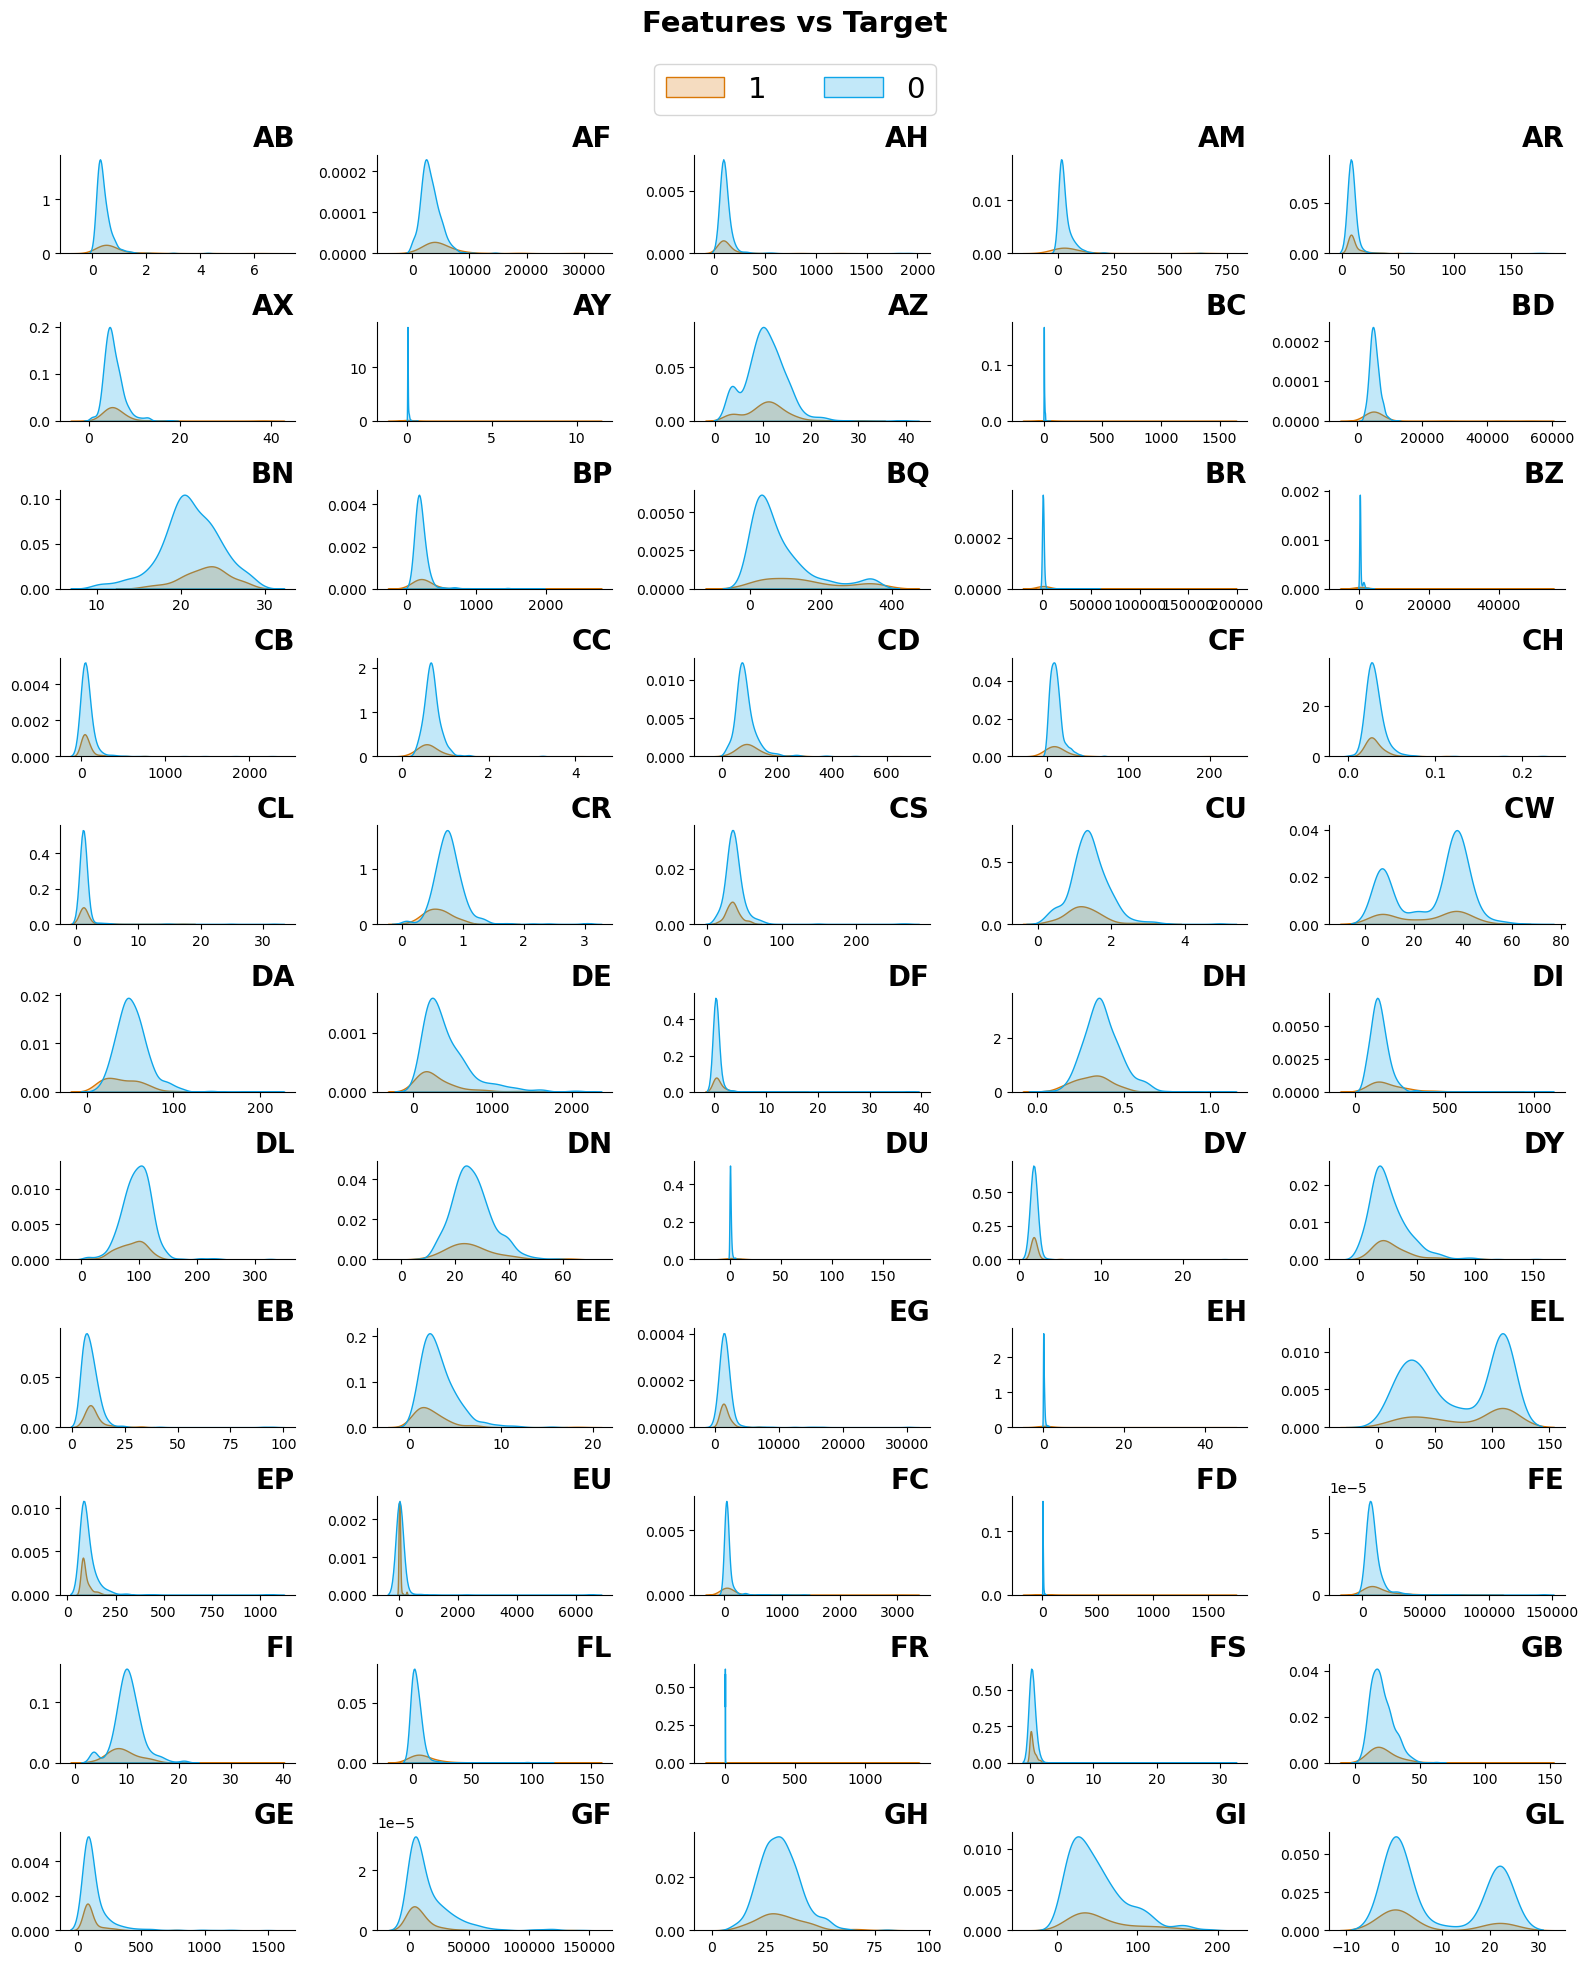

In [8]:
# Beautiful plot from https://www.kaggle.com/code/maverickss26/icr-age-related-conditions-eda-modelling
fig = plt.figure(figsize=(16, 20))
for idx, col in enumerate(train.select_dtypes(include='float64')):
    ax = plt.subplot(11,5, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=['#0ea5e9', '#d97706'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right',
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

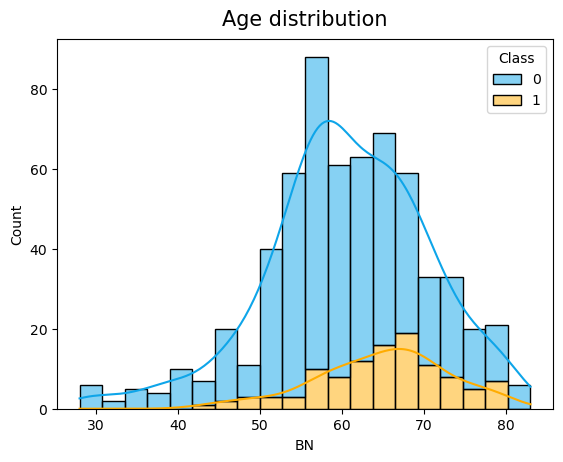

In [9]:
sns.histplot(data=pd.read_csv('/kaggle/input/icr-integer-data/train_integerized.csv'), x='BN', hue='Class', multiple='stack', palette=['#0ea5e9', '#ffac00'], kde=True)
plt.title("Age distribution", size = 15, pad = 10)
plt.show()

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📉 Integerized age :</b> To plot age distribution I'm using Raddar's <a href="https://www.kaggle.com/datasets/raddar/icr-integer-data">integerized dataset</a>. Plotting training data gives the same distribution but scaled.
</div>


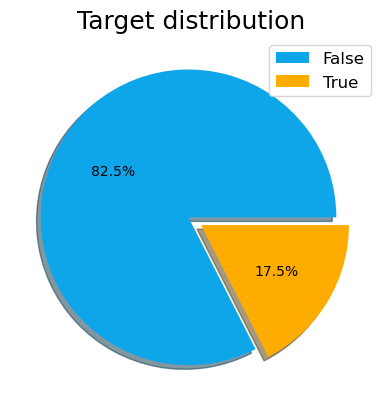

In [10]:
plt.pie(train['Class'].value_counts(), shadow=True, explode=[.05,.05], autopct='%.1f%%', colors=['#0ea5e9', '#ffac00'])
plt.title('Target distribution ', size=18)
plt.legend(['False', 'True'], loc='best', fontsize=12)
plt.show()

<div style="border-radius: 10px; border: #ffac00 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> ⚠️ Target distribution:</b> Our target classes are imballanced. This will lead to different approach in <i>modeling</i> section.
</div>

## Greeks data analysis

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📉 Greeks dataset:</b> Although this dataset is provided only for the training data. We will create <i>date</i> column for the training set and test set where date in test set will be max(date)+1.
</div>


In [11]:
greeks.head()

,Alpha,Beta,Gamma,Delta,Epsilon
Id,,,,,
000ff2bfdfe9,B,C,G,D,3/19/2019
007255e47698,A,C,M,B,Unknown
013f2bd269f5,A,C,M,B,Unknown
043ac50845d5,A,C,M,B,Unknown
044fb8a146ec,D,B,F,B,3/25/2020


In [12]:
# Convert Epsilon to datetime
greeks['Epsilon'] = pd.to_datetime(greeks['Epsilon'], errors='coerce', format='%m/%d/%Y')

In [13]:
greeks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 617 entries, 000ff2bfdfe9 to ffcca4ded3bb
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Alpha    617 non-null    object        
 1   Beta     617 non-null    object        
 2   Gamma    617 non-null    object        
 3   Delta    617 non-null    object        
 4   Epsilon  473 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 28.9+ KB


In [14]:
greeks.isnull().sum()

Alpha        0
Beta         0
Gamma        0
Delta        0
Epsilon    144
dtype: int64

<div style="border-radius: 10px; border: #ffac00 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> ⚠️ Missing values:</b> there is almost 1/4 of dates missing
</div>

In [15]:
greeks.describe(datetime_is_numeric=True)

,Epsilon
count,473
mean,2019-08-27 01:16:06.596194560
min,2012-05-17 00:00:00
25%,2019-03-11 00:00:00
50%,2019-07-29 00:00:00
75%,2020-06-01 00:00:00
max,2020-09-29 00:00:00


<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📉 Observation :</b> Half of the dates are before and half are after July of 2019. Earliest date is from May of 2012 and the latest from September of 2020. This means dates from 2019 - 2020 are more dense than ones from 2012 to 2019.
</div>

# Feature engineering 🛠️
***

## Date features

In [16]:
train['year'] = greeks['Epsilon'].dt.year
train['month'] = greeks['Epsilon'].dt.month
train['day_of_week'] = greeks['Epsilon'].dt.dayofweek
train['day'] = greeks['Epsilon'].dt.day

## Cyclic features

In [17]:
train['day_sin'] = np.sin(2 * np.pi * train['day']/31)
train['day_cos'] = np.cos(2 * np.pi * train['day']/31)

train['dayofweek_sin'] = np.sin(2 * np.pi * train['day_of_week']/6) # indexed [0, 6]
train['dayofweek_cos'] = np.cos(2 * np.pi * train['day_of_week']/6)

train['month_sin'] = np.sin(2 * np.pi * train['month']/12)
train['month_cos'] = np.cos(2 * np.pi * train['month']/12)

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> 🗓️ Cyclic nature of time :</b> In all the cases, but Year, the features should be split into two parts: sinus and cosine, to reflect cyclicity, e.g. the 1st January is near the 31st December.
</div>

## Drop columns
Now we can drop columns from which we extracted necessary information.

In [18]:
train.drop(columns=['month', 'day_of_week', 'day'], inplace=True)

# Preprocessing ⚙️
***

## Split dataset

In [19]:
X = train.drop(columns='Class', inplace=False)
y = train['Class']

## Create a pipeline

In [20]:
transformer = make_column_transformer(
    (
        SimpleImputer(strategy='median'), # fills missing values with mean of the column
        make_column_selector(dtype_include='float64')
    ),
    (
        OneHotEncoder(drop='first'),
        make_column_selector(dtype_include='object')
    ),
    remainder = 'passthrough',
    verbose_feature_names_out=False
)

In [21]:
X_transformed = transformer.fit_transform(X)
X_transformed = pd.DataFrame(data=X_transformed, columns=transformer.get_feature_names_out())
X_transformed.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GI,GL,year,day_sin,day_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,EJ_B
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,69.834944,0.120343,2019.0,-0.651372,-0.758758,8.660254e-01,0.5,1.000000e+00,6.123234e-17,1.0
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,32.131996,21.978000,2019.0,-0.201299,0.151428,1.224647e-16,-0.5,1.224647e-16,-1.836970e-16,0.0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,35.192676,0.196941,2019.0,-0.201299,0.151428,1.224647e-16,-0.5,1.224647e-16,-1.836970e-16,1.0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,90.493248,0.155829,2019.0,-0.201299,0.151428,1.224647e-16,-0.5,1.224647e-16,-1.836970e-16,1.0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,36.262628,0.096614,2020.0,-0.937752,0.347305,8.660254e-01,-0.5,1.000000e+00,6.123234e-17,1.0


<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b> Because of very small dataset I won't split <i>X_transformed</i> into test set that our models hasn't seen before. Data is much more valuable in this case. Let's hope cross validation score gives us good enough estimate of models performance.
</div>

<div style="border-radius: 10px; border: #00d65c solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📖 Note :</b> It's very important that our validation set comes from the same distribution as test set so there should be class imbalance in it beacues we assume that there will be imbalance in a test set! Training set can come from a slightly different distribution. You will see me sticking to that rule in the cross validation step.
</div>

# PCA visualization 👀
***

In [22]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_transformed)

# Create a dataframe with the PCA data and the target variable
df = pd.DataFrame({'x': X_pca[:, 0], 'y' : X_pca[:, 1], 'z' : X_pca[:, 2], 'has disease': y})

# Create a 3D scatter plot with color-coded points
fig = px.scatter_3d(df, x='x', y='y', z='z', color='has disease')

fig.show()

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📉 Observation :</b> That is a wierd PCA. But we can see most diseased patients are in the "corner". But there is some pattern in this data even in the PCA so that is a good sign. Maybe this comp isn't that random.
</div>

# Modeling 🪄
***

## Balanced logarithmic loss

In [23]:
# Function created by Robert Trypuz. Comment section: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/410864
def balanced_log_loss(y_true, y_pred):
    # N_i is the number of observations
    N_1 = np.sum(y_true == 1, axis=0)
    N_0 = np.sum(y_true == 0, axis=0)

    # In order to avoid the extremes of the log function, each predicted probability p is replaced with max(min(p,1−10−15),10−15)
    y_pred = np.maximum(np.minimum(y_pred, 1 - 1e-15), 1e-15)

    # Balanced logarithmic loss
    loss_numerator = - (1/N_0) * np.sum((1 - y_true) * np.log(1-y_pred)) - (1/N_1) * np.sum(y_true * np.log(y_pred))

    return loss_numerator / 2

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> 🖊️ Note :</b> This is corrected version of balanced log loss which is used to evaluate submissions. <i>y_pred</i> is list of propabilities of example being class 1. This will later be useful to extract needed propablities from <i>predict_proba</i> method.
</div>

In [24]:
balanced_log_loss_scorer = make_scorer(balanced_log_loss, greater_is_better=False, needs_proba=True) # for y_true, y_predict = -x, where x is the balanced log loss

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> 🖊️ make_scorer :</b> is a function from the scikit-learn library that creates a callable scorer object from a performance metric or loss function. It is used to create scorer objects for use with scikit-learn’s model selection and evaluation tools, such as <i>cross_val_score</i> and <i>GridSearchCV</i>.
</div>

## Hyperparameter optimization
Let me show you the correct way to perform cross validation with oversampling without data leaks! Also I've run this optimizing function for each of the models and saved best hyperparameters as `best_hyperparams_[model]` that is why they are commented out.

In [25]:
def objective(trial):
    # STEP 1: create a model with hyperparameter ranges
    
#     model = CatBoostClassifier(
#         iterations = trial.suggest_int('iterations', 100, 300),
#         learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3),
#         depth = trial.suggest_int('depth', 1, 10), # depth above 10 usually introduces overfitting
#         l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.2, 10),
#         early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 1, 20),
#         auto_class_weights = 'Balanced',
#         loss_function = 'Logloss',
#         verbose = 0
#     )

#     model = XGBClassifier(
#         eta = trial.suggest_float('eta', 0.001, 0.3),
#         n_estimators = trial.suggest_int('n_estimators', 64, 512),
#         max_depth = trial.suggest_int('max_depth', 1, 10),
#         max_leaves = trial.suggest_int('max_leaves', 0, 1024),
#         reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10),
#         subsample = trial.suggest_float('subsample', 0.5, 1),
#         min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
#         colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1),
#         scale_pos_weight = 82.5/17.5, # ratio of negative to positive class
#         tree_method = 'gpu_hist',
#         predictor = 'gpu_predictor',
#         obj = balanced_log_loss
#     )

#     model = LGBMClassifier(
#         learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3),
#         n_estimators = trial.suggest_int('n_estimators', 64, 512),
#         max_depth = trial.suggest_int('max_depth', 1, 10),
#         num_leaves = trial.suggest_int('num_leaves', 2, 1024),
#         reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10),
#         subsample = trial.suggest_float('subsample', 0.5, 1),
#         min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
#         colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1),
#         class_weight='balanced'
#     )

#     model = SVC(
#         C = trial.suggest_float('C', 0.01, 10),
#         degree = trial.suggest_int('degree', 1, 5),
#         gamma = trial.suggest_float('gamma', 0.01, 10),
#         probability = True
#     )

    
    # STEP 2: create a pipline that syntheticly upsamples given dataset and fits if to the model
    pipeline = Pipeline([
#         ('smote', SMOTE()),
        ('model', model)
    ])

    # STEP 3: Get 5 fold cross validation scores
    scores = cross_val_score(pipeline, X_transformed, y, scoring=balanced_log_loss_scorer, cv=5)
    
    # STEP 4: return overall model cross validation score
    return -scores.mean()

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# best_hyperparams = study.best_params

<div style="border-radius: 10px; border: #00d65c solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>✅ No upsampling :</b> Finally I decided not to use upsamplig and go with class weights.
</div>

<div style="background-color: #e0f2fe; border-left: 6px solid #0ea5e9; font-size: 100%; padding: 10px;">
    <h3 style="color: #0ea5e9; font-size: 18px; margin-top: 0; margin-bottom: 10px;">Cross validation step by step</h3>
    This section is a fragment of my discussion post <a href="https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/429051">here</a>.
    <ol>
        <li>Pipeline upsamples our 4 folds and fits our model on the upsampled data so our model sees more of minority class hence gets better performance.</li>
        <li>It upsamples our 4 folds and fits it to our model so it sees more of minority class hence gets better performance (training data can come from different distribution, but validation and testing set must come from the same).</li>
        <li>We evaluate our model based of 5th fold that is not upsampled because it wasn’t passed to the pipeline using our <i>balanced_log_loss_scorer</i>.</li>
        <li>This process is repeated 5 times. Each time validation fold changes and rest goes to training</li>
    </ol>
</div>
<div style="background-color: #e0f2fe; border-left: 6px solid #0ea5e9; font-size: 100%; padding: 10px;">
    <h3 style="color: #0ea5e9; font-size: 18px; margin-top: 0; margin-bottom: 10px;">Why is this the right implementation of CV?</h3>
    <ul>
        <li>By upsampling only the train set, we prevent data leakage and avoid inflating the validation score. If we upsampled the data before splitting it, we could end up with synthetic examples in the validation set that are duplicates or near-duplicates of the ones in the train set. The model would then recognize those examples and perform better on the validation set than it should, misleading us into thinking that the model is more accurate than it really is.

</li>
        <li>By leaving the validation set not upsampled, we maintain the original distribution of classes in the validation and test sets. This is important because the validation and test sets should have the same distribution. If we upsampled the validation set, we would change the class ratio and make it more balanced than the test set, which we assume is imbalanced. This would distort the target distribution and reduce the validity of the validation score.</li>
        <li>It is neat and elegant.</li>
    </ul>
</div>

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> 🖊️ Custom loss :</b> Custom objective functions are allowed only in a <i>XGBClassifier</i> and <i>CatBoostClassifer</i> (catboost needs more complex implementation).
</div>

In [26]:
best_hyperparams_cat  = {'iterations': 218, 'learning_rate': 0.08714579299481419, 'depth': 4, 'l2_leaf_reg': 9.012019172601832, 'early_stopping_rounds': 17}
best_hyperparams_xgb  = {'eta': 0.0806331265899514, 'n_estimators': 187, 'max_depth': 4, 'max_leaves': 907, 'reg_lambda': 7.691698183513105, 'subsample': 0.9257907565125556, 'min_child_weight': 4, 'colsample_bytree': 0.7719688375530194}
best_hyperparams_lgbm = {'learning_rate': 0.17499729963699245, 'n_estimators': 117, 'max_depth': 4, 'num_leaves': 323, 'reg_lambda': 9.310940611498339, 'subsample': 0.5801922390143082, 'min_child_weight': 6, 'colsample_bytree': 0.7585938709411622}

## Stacking models

In [27]:
estimators = [
    ('CatBoostClassifier', CatBoostClassifier(**best_hyperparams_cat,  verbose=0, auto_class_weights = 'Balanced')),
    ('XGBClassifier', XGBClassifier(**best_hyperparams_xgb, scale_pos_weight = 82.5/17.5)),
#     ('TabPFNClassiffier_1', TabPFNClassifier(N_ensemble_configurations=24)),
#     ('TabPFNClassiffier_1', TabPFNClassifier(N_ensemble_configurations=64))
]

stacked_model = StackingClassifier(estimators=estimators, final_estimator=LGBMClassifier(**best_hyperparams_lgbm, class_weight='balanced'))

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> 🖊️ Note :</b> scale_pos_weight hyperparameter improve models performence in the leaderboard. Only cv it went from 0.03 to 0.045 so it performed worse on a cv but LB is more important.
</div>

## Model evaluation

In [28]:
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

log_loss_list = []

for train_index, val_index in skf.split(X_transformed, y):
    stacked_model.fit(X_transformed.iloc[train_index], y.iloc[train_index])
    
    log_loss_list.append((
            balanced_log_loss(y.iloc[train_index], stacked_model.predict_proba(X_transformed.iloc[train_index])[:, 1]),
            balanced_log_loss(y.iloc[val_index], stacked_model.predict_proba(X_transformed.iloc[val_index])[:, 1])
    ))

print('Loss on training:', sum(row[0] for row in log_loss_list) / len(log_loss_list))
print('Loss on validation:', sum(row[1] for row in log_loss_list) / len(log_loss_list))

Loss on training: 0.03974619653780177
Loss on validation: 0.2372350759416169


In [29]:
stacked_model.fit(X_transformed, y)

StackingClassifier(estimators=[('CatBoostClassifier',
                                <catboost.core.CatBoostClassifier object at 0x7874901a3c10>),
                               ('XGBClassifier',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7719688375530194,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eta=0.0806331265899514,
                                              eval_met...
                                              min_child_weight=4, missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=187, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, ...))],
                   final_estimator=LGBMClassifier(class_weight='balanced',
                                                  colsample_bytree=0.7585938709411622,
                                                  learning_rate=0.17499729963699245,
                                                  max_depth=4,
                                                  min_child_weight=6,
                                                  n_estimators=117,
                                                  num_leaves=323,
                                                  reg_lambda=9.310940611498339,
                                                  subsample=0.5801922390143082))

# Submission 🏆
***
Now we can apply every transformation on a test set step by step like we did on a training set.

In [30]:
X_test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')

latest_date = greeks['Epsilon'].max()

X_test['year'] = latest_date.year
X_test['month'] = latest_date.month
X_test['day_of_week'] = latest_date.dayofweek
X_test['day'] = latest_date.day

X_test['day_sin'] = np.sin(2 * np.pi * X_test['day']/31)
X_test['day_cos'] = np.cos(2 * np.pi * X_test['day']/31)

X_test['dayofweek_sin'] = np.sin(2 * np.pi * X_test['day_of_week']/6) # indexed [0, 6]
X_test['dayofweek_cos'] = np.cos(2 * np.pi * X_test['day_of_week']/6)

X_test['month_sin'] = np.sin(2 * np.pi * X_test['month']/12)
X_test['month_cos'] = np.cos(2 * np.pi * X_test['month']/12)

X_test.drop(columns=['month', 'day_of_week', 'day'], inplace=True)

X_test_transformed = transformer.transform(X_test)

In [31]:
predictions = stacked_model.predict_proba(X_test_transformed)

In [32]:
sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv', index_col='Id')
sample_submission[['class_0', 'class_1']] = predictions
sample_submission.to_csv('/kaggle/working/submission.csv')
sample_submission.head()

,class_0,class_1
Id,,
00eed32682bb,0.536957,0.463043
010ebe33f668,0.536957,0.463043
02fa521e1838,0.536957,0.463043
040e15f562a2,0.536957,0.463043
046e85c7cc7f,0.536957,0.463043


# Thank you ✨

I hope you enjoyed this notebook and learned something new. 😊 If you did, please consider upvoting it and leaving a comment. I would love to hear your feedback and suggestions. 💬

Also, feel free to fork this notebook and experiment with different models, features, and techniques.

Thank you for reading and happy kaggling! 🚀